In [1]:
# nEpochs=20  # orig, longer training
nEpochs = 3  # quick testing during development
%set_env CUDA_VISIBLE_DEVICES=1
%cd 04_ExerciseCodeAndInstructions/HPO

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = False
USE_CVAECGAN = True

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception(
        "Double check you are only using one model. The current model name is invalid"
    )


env: CUDA_VISIBLE_DEVICES=1
/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/HPO


## 1. Import 3rd party libraries 

In [2]:
import os
import session_info

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")

# Import our own classes
from vaegan.data import MNIST
from vaegan.conditional.callbacks import (
    GenerateImagesConditional,
    SaveImagesConditional,
)
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

# session_info.show()


2025-05-30 12:38:14.563679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748626694.586717   43099 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748626694.593648   43099 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748626694.610947   43099 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748626694.610965   43099 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748626694.610967   43099 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748626699.719481   43099 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3300 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


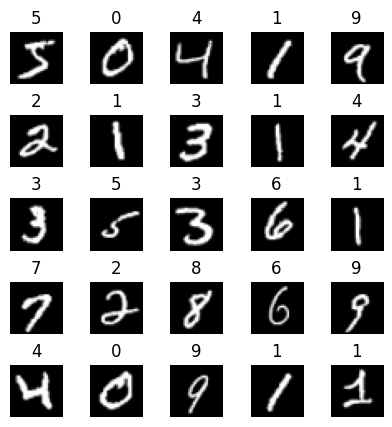

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = "./outputs/mnist" + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)

# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, depth=n_classes, dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, "example_images.png"))


## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    "n_latent_dims": 4,
    "learning_rate": 0.001,
    "encoder_params": {
        "conv_layer_units": [16, 64],
        "conv_layer_kernel_size": [4, 4, 4, 4],
        "conv_layer_strides": [(1, 1), (2, 2)],
        "conv_layer_activation_function": ["relu", "relu"],
        "encoder_dense_layer_units": [128],
        "decoder_dense_layer_units": [],
    },
    "decoder_params": {
        "conv_layer_units": [16, 64],
        "conv_layer_kernel_size": [4, 4],
        "conv_layer_strides": [(1, 1), (2, 2)],
        "conv_layer_activation_function": ["relu", "relu"],
        "encoder_dense_layer_units": [128],
        "decoder_dense_layer_units": [],
    },
    "generator_params": {
        "generator_conv_layer_units": [128, 128],
        "generator_conv_layer_kernel_size": [4, 4],
        "generator_conv_layer_strides": [(2, 2), (2, 2)],
        "generator_conv_layer_activation_functions": [
            tf.nn.leaky_relu,
            tf.nn.leaky_relu,
        ],
        "discriminator_dense_layer_units": [128],
        "generator_dense_layer_units": [],
    },
    "discriminator_params": {
        "discriminator_conv_layer_units": [32, 64],
        "discriminator_conv_layer_kernel_size": [4, 4],
        "discriminator_conv_layer_strides": [(1, 1), (2, 2)],
        "discriminator_conv_layer_activation_functions": ["relu", "relu"],
        "discriminator_dense_layer_units": [],
        "generator_dense_layer_units": [],
    },
}

if USE_CGAN:
    model = ConditionalGAN(
        n_classes=n_classes,
        n_latent_dims=hpo_params["n_latent_dims"],
        generator_params=hpo_params["generator_params"],
        discriminator_params=hpo_params["discriminator_params"],
    )
if USE_CVAE:
    model = ConditionalVAE(
        n_classes=n_classes,
        n_latent_dims=hpo_params["n_latent_dims"],
        encoder_params=hpo_params["encoder_params"],
        decoder_params=hpo_params["decoder_params"],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(
        adv_loss_weight=10.0,
        n_classes=n_classes,
        n_latent_dims=hpo_params["n_latent_dims"],
        encoder_params=hpo_params["encoder_params"],
        decoder_params=hpo_params["decoder_params"],
        discriminator_params=hpo_params["discriminator_params"],
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# if USE_CVAE or USE_CVAECGAN:
#     model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
# if USE_CGAN or USE_CVAECGAN:
#     model.discriminator.compute_output_shape((None, 32, 32, 1))


In [5]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,))
    gen_out = model.generator.call(gen_in)
    gen = tf.keras.Model(gen_in, gen_out)
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input((model.image_shape,))
    disc_out = model.discriminator.call(disc_in)
    disc = tf.keras.Model(disc_in, disc_out)
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input(
        (
            32,
            32,
            1 + model.n_classes,
        )
    )  # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out = model.encoder.call(enc_in)
    enc = tf.keras.Model(enc_in, enc_out)
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,))
    dec_out = model.decoder.call(dec_in)
    dec = tf.keras.Model(dec_in, dec_out)
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input(
        (
            32,
            32,
            1 + model.n_classes,
        )
    )  # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out = model.encoder.call(enc_in)
    enc = tf.keras.Model(enc_in, enc_out)
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,))
    dec_out = model.decoder.call(dec_in)
    dec = tf.keras.Model(dec_in, dec_out)
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape)
    disc_out = model.discriminator.call(disc_in)
    disc = tf.keras.Model(disc_in, disc_out)
    disc.summary()


=== OVERALL MODEL ====


Model: "cvaecgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator                   │ ?                      │   0 (unbuilt) │
│ (MultiTaskDiscriminator)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │      2,832 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     16,448 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense0 (Dense)      │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 4)         │        516 │ dense0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 4)         │        516 │ dense0[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,117,912 (8.08 MB)

 Trainable params: 2,117,752 (8.08 MB)

 Non-trainable params: 160 (640.00 B)

=== DECODER SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 16384)          │       245,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (Activation)              │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,097 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 160 (640.00 B)

=== DISCRIMINATOR SUBMODEL ====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        544 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        128 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     32,832 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_real (Dense)  │ (None, 1)         │     16,385 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_class (Dense) │ (None, 10)        │    163,850 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_real        │ (None, 1)         │          0 │ dense_real[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_class       │ (None, 10)        │          0 │ dense_class[0][0] │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,995 (835.92 KB)

 Trainable params: 213,803 (835.17 KB)

 Non-trainable params: 192 (768.00 B)

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])


/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'cvaecgan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1748626703.415993   43099 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params["learning_rate"])
)

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(
        output_dir=output_dir,
        model=model,
        example_labels=labels_onehot[:10],
        n_generated_images=10,
        n_latent_dims=model.n_latent_dims,
    )
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(
        output_dir=output_dir,
        model=model,
        example_images=data.images_train[:10],
        example_labels=labels_onehot[:10],
        n_generated_images=10,
        n_latent_dims=model.n_latent_dims,
    )


## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.

logs = model.fit(
    [data.images_train, labels_onehot],
    batch_size=128,
    epochs=nEpochs,
    callbacks=[save_images_callback],
)


Epoch 1/3


I0000 00:00:1748626711.708749   43415 service.cc:152] XLA service 0x2aae84001a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748626711.708800   43415 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/469 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - class_loss: 3.2098 - dec_loss: 319.6877 - disc_loss: 3.5600 - enc_loss: 812.2441 - kl_loss: 492.0659 - recon_loss: 320.1782 - top_1_acc: 0.1931 

I0000 00:00:1748626721.103310   43415 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - class_loss: 0.3996 - dec_loss: 98.0794 - disc_loss: 0.4105 - enc_loss: 160.4622 - kl_loss: 63.1722 - recon_loss: 97.2900 - top_1_acc: 0.8942
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0577 - dec_loss: 33.9196 - disc_loss: 0.0580 - enc_loss: 40.4172 - kl_loss: 6.5301 - recon_loss: 33.8871 - top_1_acc: 0.9816
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0378 - dec_loss: 28.3909 - disc_loss: 0.0386 - enc_loss: 33.9900 - kl_loss: 5.6111 - recon_loss: 28.3789 - top_1_acc: 0.9884


## 8. Training saves results to disk, now also plot training curves

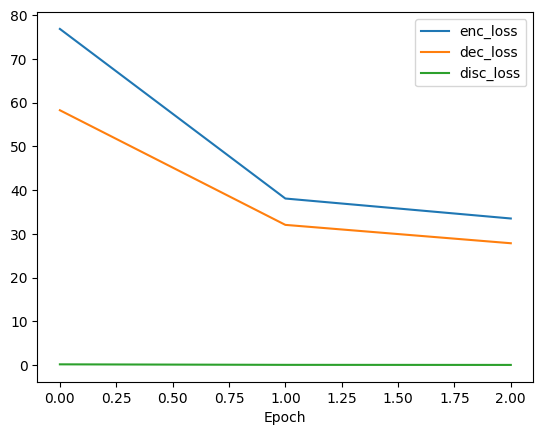

In [9]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ["enc_loss", "dec_loss", "disc_loss", "gen_loss"]:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)

ax.legend()
ax.set_xlabel("Epoch")
fig.savefig(os.path.join(output_dir, "training_curves.png"), transparent=False)
# fig.show()

# Save the model
model.save(
    os.path.join(
        output_dir,
        model_name + ".keras",
    )
)


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


Testing with n_latent_dims=4
Testing with learning_rate=0.001
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - class_loss: 0.3919 - dec_loss: 75.4526 - disc_loss: 0.4072 - enc_loss: 186.3799 - kl_loss: 111.4108 - recon_loss: 74.9691 - top_1_acc: 0.8942
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0553 - dec_loss: 34.5843 - disc_loss: 0.0555 - enc_loss: 41.0257 - kl_loss: 6.4733 - recon_loss: 34.5523 - top_1_acc: 0.9820
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0335 - dec_loss: 30.0858 - disc_loss: 0.0343 - enc_loss: 35.9206 - kl_loss: 5.8499 - recon_loss: 30.0708 - top_1_acc: 0.9894
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0281 - dec_loss: 27.7178 - disc_loss: 0.0290 - enc_loss: 33.5470 - kl_loss: 5.8352 - recon_loss: 27.7117 - top_1_acc: 0.9913
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0214 - dec_loss: 26.1694 - disc_loss: 0.0398 - enc_loss: 32.1175 - kl_loss: 5.7783 - 

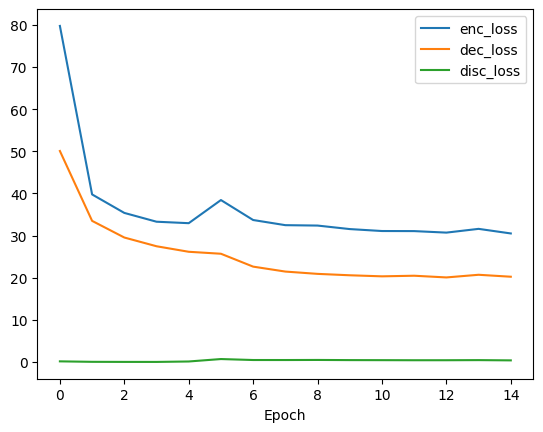

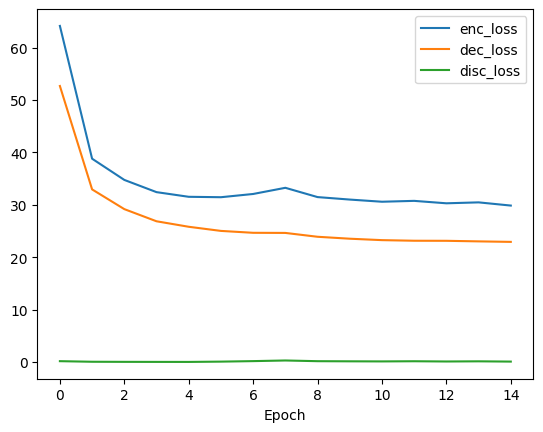

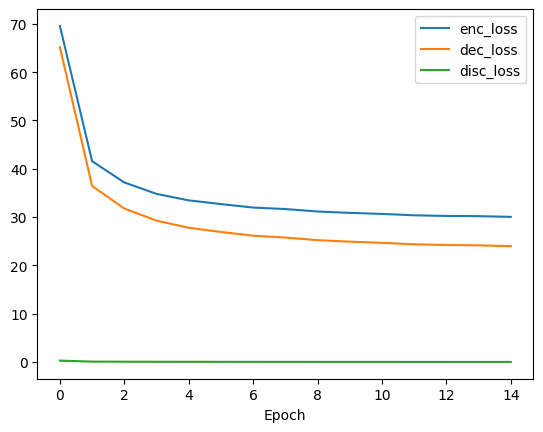

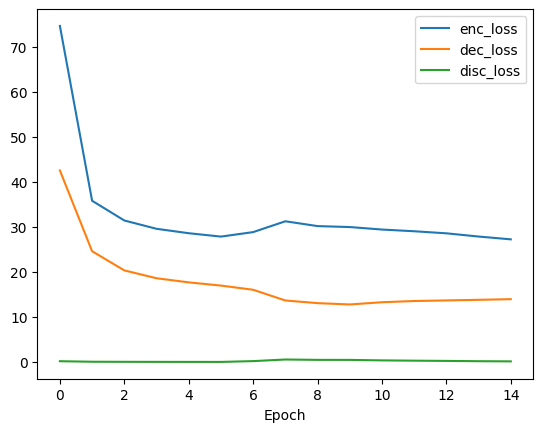

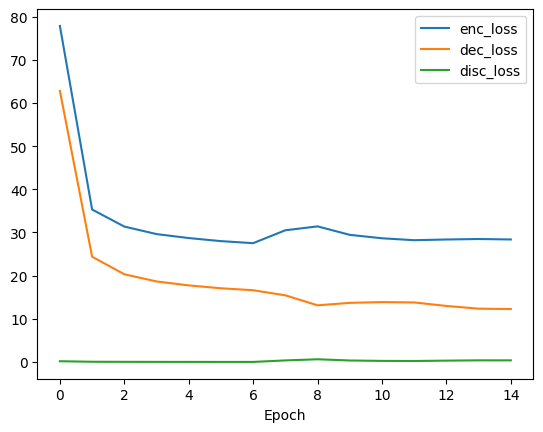

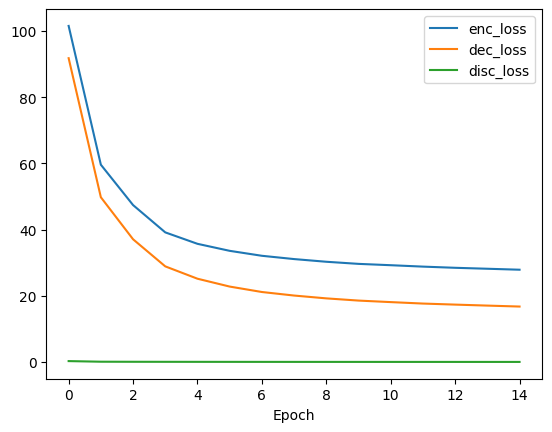

In [17]:
# Hyperparameter Optimization (HPO) Loop
nEpochs = 15  # less than 20 to speed up the HPO loop
for n_latent_dims in [4, 16, 32]:
    for learning_rate in [0.001, 0.0005, 0.0001]:
        tf.random.set_seed(1234)
        output_dir = (
            "./outputs/mnist_hpo_cvaecgan_"
            + str(learning_rate)
            + "_"
            + str(n_latent_dims)
        )
        os.makedirs(output_dir, exist_ok=True)
        print(f"Testing with n_latent_dims={n_latent_dims}")
        print(f"Testing with learning_rate={learning_rate}")
        hpo_params["n_latent_dims"] = n_latent_dims
        hpo_params["learning_rate"] = learning_rate
        model = ConditionalVAECGAN(
            adv_loss_weight=10.0,
            n_classes=n_classes,
            n_latent_dims=hpo_params["n_latent_dims"],
            encoder_params=hpo_params["encoder_params"],
            decoder_params=hpo_params["decoder_params"],
            discriminator_params=hpo_params["discriminator_params"],
            name=f"cvaecgan_hpo_nLatentDims_{n_latent_dims}_lr_{learning_rate}",
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hpo_params["learning_rate"]
            )
        )
        save_images_callback = SaveImagesConditional(
            output_dir=output_dir,
            model=model,
            example_images=data.images_train[:10],
            example_labels=labels_onehot[:10],
            n_generated_images=10,
            n_latent_dims=model.n_latent_dims,
        )
        logs = model.fit(
            [data.images_train, labels_onehot],
            batch_size=128,
            epochs=nEpochs,
            callbacks=[save_images_callback],
        )

        fig, ax = plt.subplots()

        for loss_name in ["enc_loss", "dec_loss", "disc_loss", "gen_loss"]:
            if loss_name in logs.history.keys():
                loss_values = logs.history[loss_name]
                x = np.arange(len(loss_values))
                ax.plot(x, loss_values, label=loss_name)

        ax.legend()
        ax.set_xlabel("Epoch")
        fig.savefig(os.path.join(output_dir, "training_curves.png"), transparent=False)
        # fig.show()

        # Save the model
        model.save(
            os.path.join(
                output_dir,
                model_name + ".keras",
            )
        )


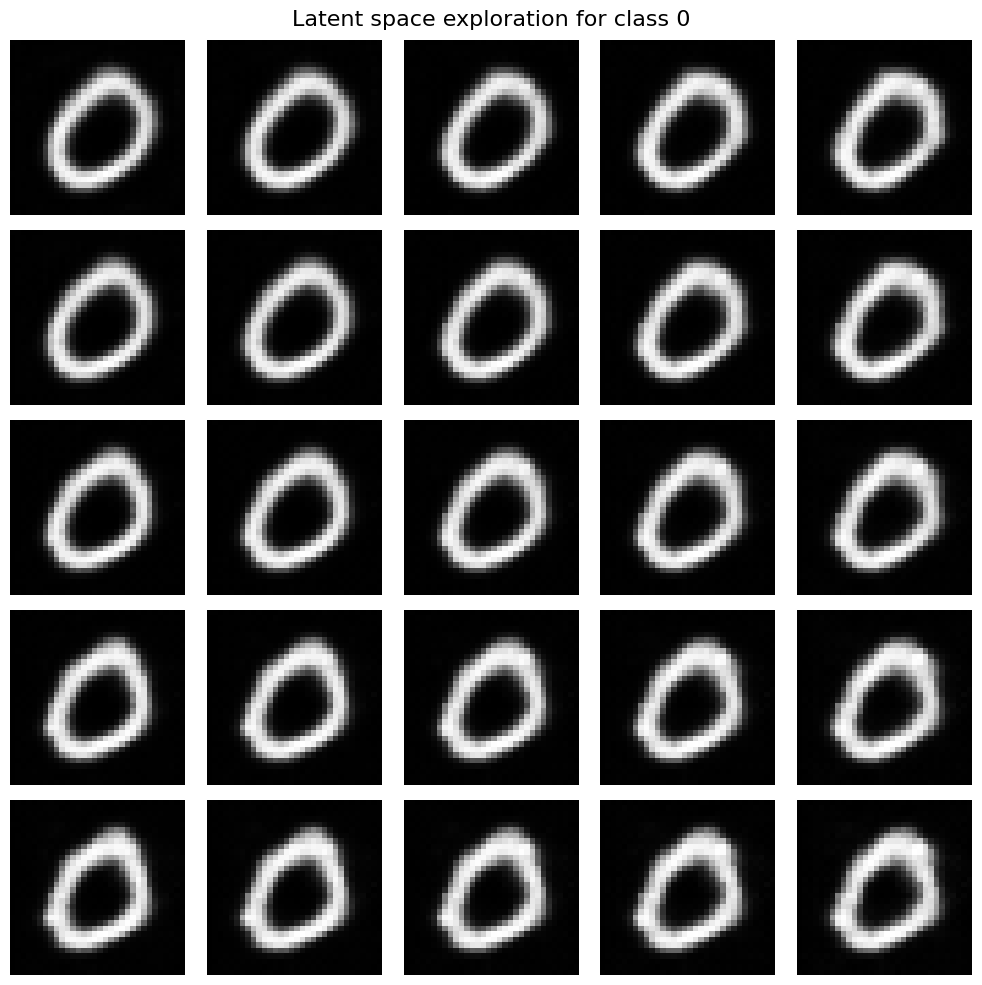

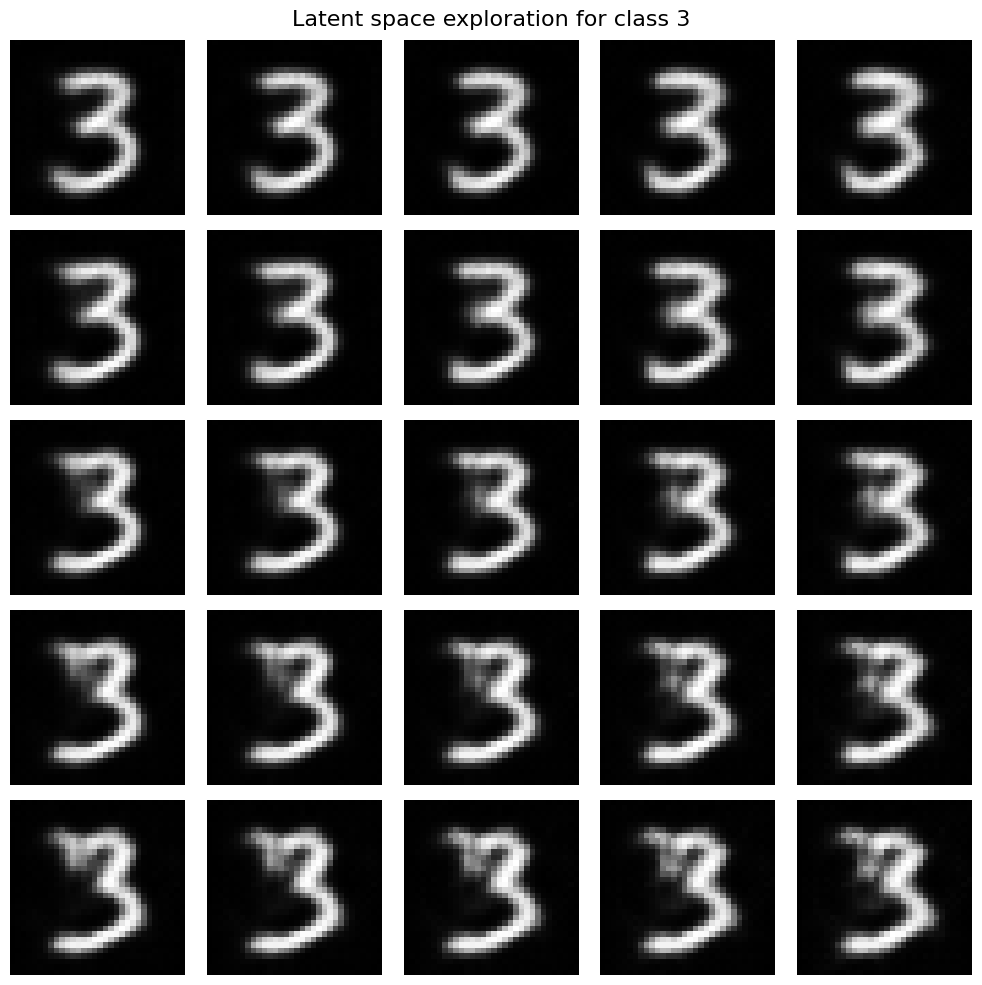

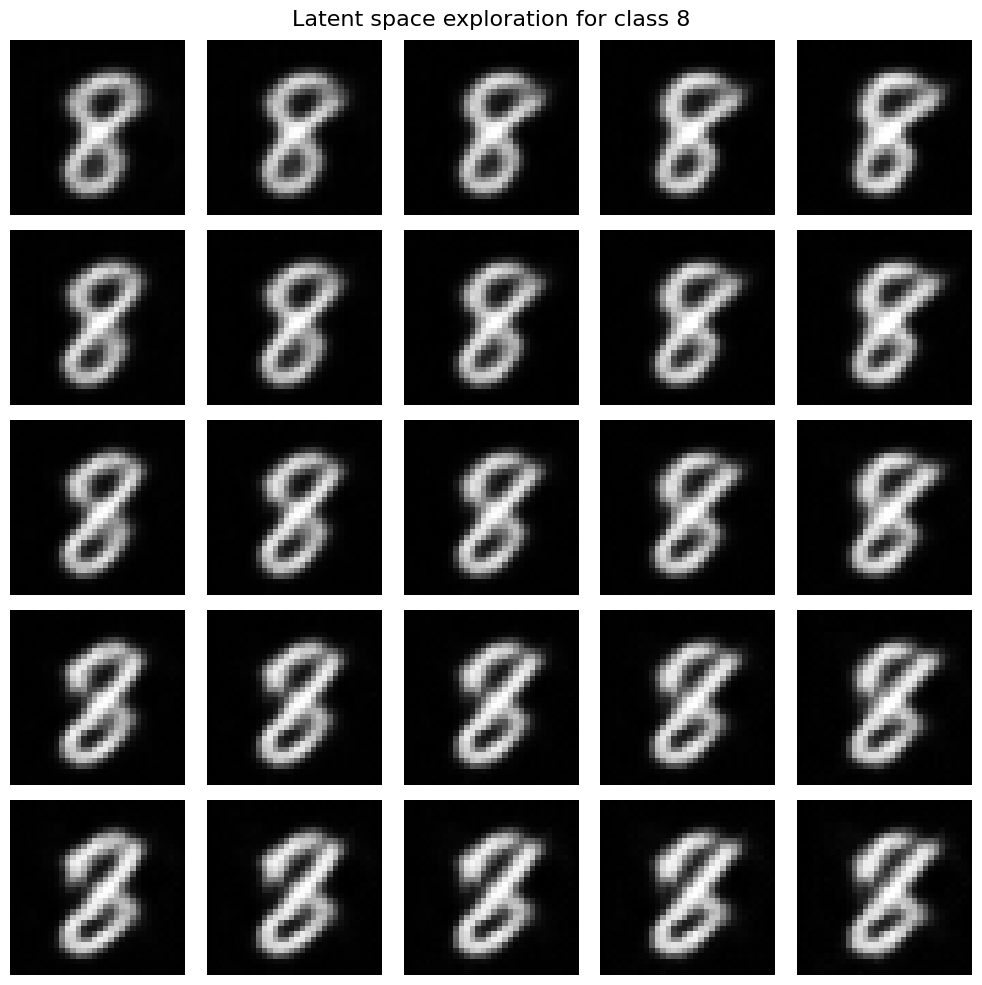

In [20]:
output_dir = "./outputs/latent_space_exploration"
os.makedirs(output_dir, exist_ok=True)

for class_label in [0, 3, 8]:
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    axs = axs.flatten()

    z = np.zeros((25, model.n_latent_dims))

    y = tf.one_hot([class_label] * 25, depth=model.n_classes)
    values = np.linspace(0, 10, 5)
    for i, x_val in enumerate(values):
        for j, y_val in enumerate(values):
            idx = i * 5 + j
            z[idx, 0] = x_val
            z[idx, 1] = y_val

    # Generate images using the model
    images = model.decoder(tf.concat([z, y], -1)).numpy()

    # Plot the images in the 5x5 grid
    for i in range(25):
        axs[i].imshow(images[i, :, :, 0], cmap="gray")
        axs[i].axis("off")

    # Add a title for this class
    fig.suptitle(f"Latent space exploration for class {class_label}", fontsize=16)
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(output_dir, f"latent_space_class_{class_label}.png"))
    plt.show()
